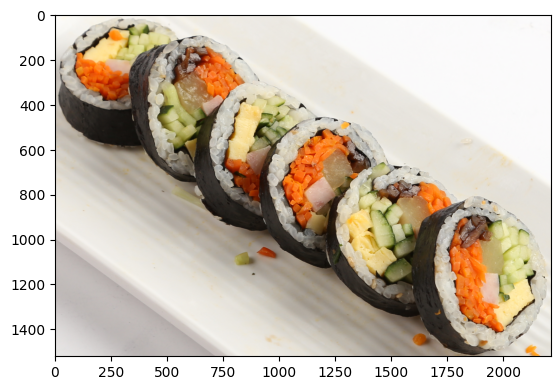

In [14]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
imgpath = r'D:\data\New_sample\원천데이터\합본_양추정_이미지_TRAIN\image\김밥\Q3\side_주먹밥김밥류_접시_김밥_Q3_00007.jpg'
img = Image.open(imgpath)
# imgarr = np.shape(img)
imgarr = np.array(img)
plt.imshow(imgarr[980:2501, 1254:3466, :])